In [2]:
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)


Dataset created in /home/csimmon2/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


In [3]:
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data, datasets
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
sub_info = sub_info[sub_info['group'] == 'control']
#subs = sub_info['sub'].tolist()
subs = ['sub-025']

run_num = 3
runs = list(range(1, run_num + 1))

# Define the number of ROIs for the Schaefer atlas
n_rois = 200  # You can adjust this value as needed

def apply_schaefer_atlas(subject_data, atlas_img, n_rois):
    # Resample atlas to subject space
    resampled_atlas = image.resample_to_img(atlas_img, subject_data, interpolation='nearest') # consider the interpolation method 
    
    # Extract time series data ##to check
    atlas_masker = input_data.NiftiLabelsMasker(labels_img=resampled_atlas, 
                                                standardize=True,
                                                memory='nilearn_cache', 
                                                verbose=0)
    time_series = atlas_masker.fit_transform(subject_data)
    
    return time_series

def create_connectivity_matrix(ss):
    logging.info(f"Processing subject: {ss}")
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=7, resolution_mm=2) ###7???
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load subject data for this run
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Run data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Apply Schaefer atlas and extract time series
        run_data = apply_schaefer_atlas(subject_img, atlas_img, n_rois)
        all_runs_data.append(run_data)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save the connectivity matrix
            output_dir = f'{results_dir}/connectivity_matrices'
            os.makedirs(output_dir, exist_ok=True)
            np.save(f'{output_dir}/{ss}_connectivity_matrix.npy', connectivity_matrix)
            logging.info(f'Saved connectivity matrix for {ss}')

if __name__ == "__main__":
    main()

2024-10-19 15:06:50,520 - INFO - Processing subject: sub-025
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/maskers/nifti_labels_masker.py:617: UserWarning: Persisting input arguments took 17.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(
2024-10-19 15:14:17,462 - INFO - Saved connectivity matrix for sub-025


ValueError: 'adjacency_matrix' is supposed to have shape (n, n). Its shape was ()

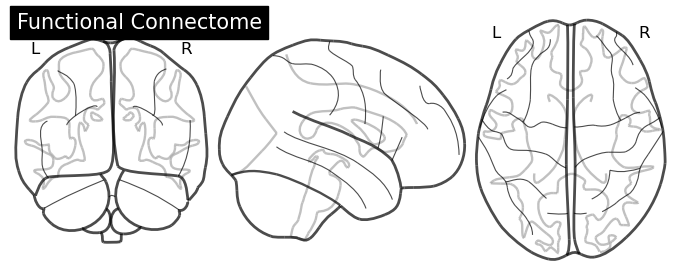

In [9]:
from nilearn import plotting

def visualize_connectome(connectivity_matrix, atlas):
    coords = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)
    plotting.plot_connectome(connectivity_matrix, coords, 
                             title='Functional Connectome')
    plt.savefig(f'{output_dir}/{ss}_connectome.png')
    #plt.close()

connectivity_matrix = f'results/connectivity_matrices/sub-025_connectivity_matrix.npy'
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, resolution_mm=2)

visualize_connectome(connectivity_matrix, atlas)
# Call this function after creating the connectivity matrix in your main function

NameError: name 'plt' is not defined

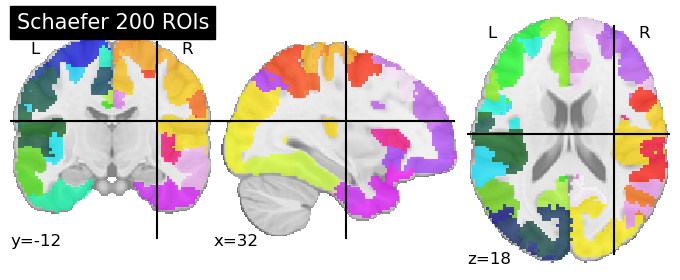

In [4]:
from nilearn import plotting

def visualize_atlas(atlas):
    plotting.plot_roi(atlas.maps, title='Schaefer 200 ROIs')
    plt.savefig(f'{output_dir}/schaefer_200_atlas.png')
    #plt.close()

# Call this function after loading the atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
visualize_atlas(atlas)